# Introduction

In this notebook, I would like to investigate the use of pairwise covariance matrices to impute data.

## Simulated Data

First off, let's simulate data drawn from a multivariate normal. Three columns of data, columns A, B, and C, for which we know the ground-truth covariance matrix between all 3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data = np.random.multivariate_normal(mean=[0, 6, 2], cov=[[1, 0.5, 0.9], [0.5, 1, 0.8], [0.9, 0.8, 1]], size=1000)
df = pd.DataFrame(data)

In [3]:
data.shape

(1000, 3)

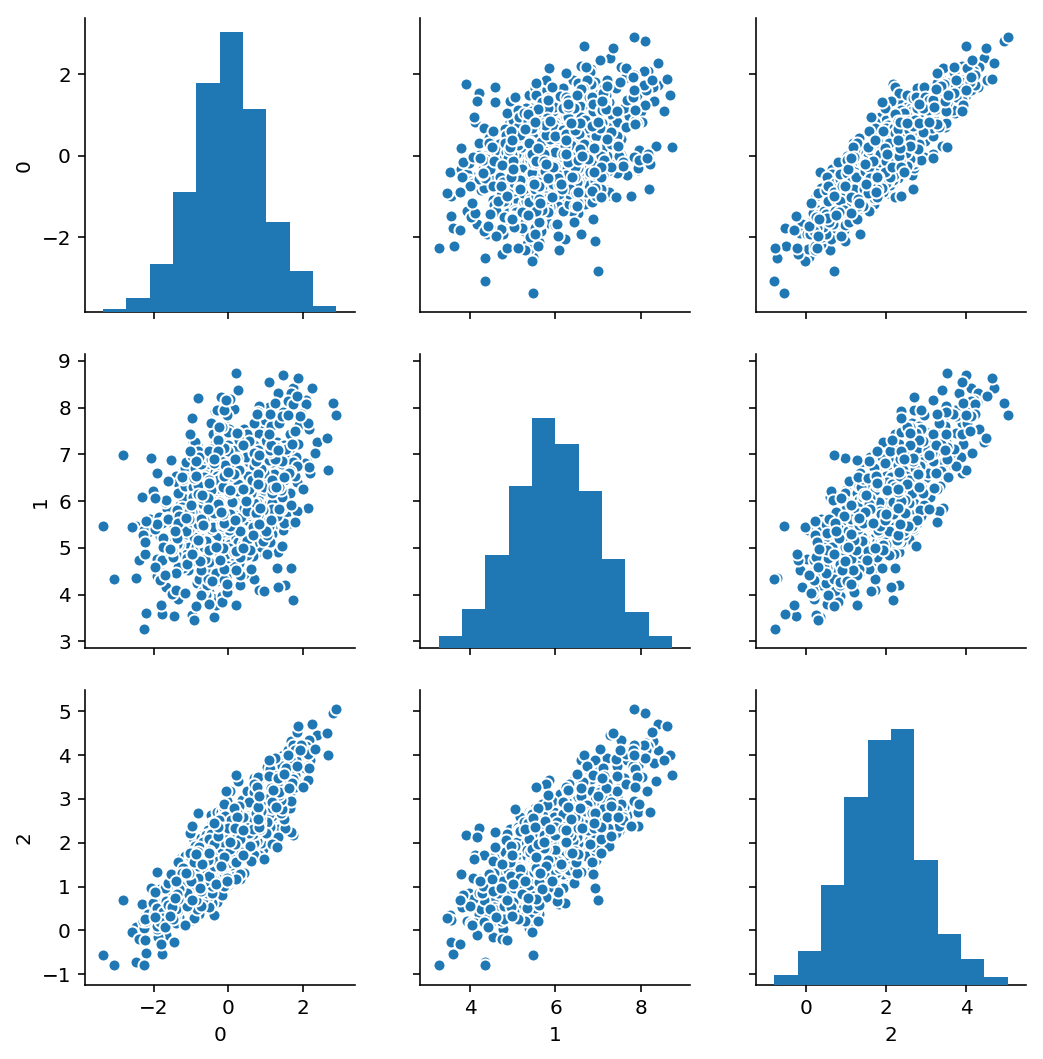

In [4]:
sns.pairplot(pd.DataFrame(data))

Now, let's simulate the case where a dropout mask is applied on 80% of the data.

In [5]:
mask = np.random.binomial(n=1, p=0.2, size=data.shape)

In [6]:
ind = np.where(mask.flatten() == 0)
ind

(array([   0,    1,    2, ..., 2997, 2998, 2999]),)

In [7]:
data_masked = mask * data

In [8]:
np.put(data_masked, ind, np.nan)

In [9]:
pd.DataFrame(data_masked)

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,3.407545
2,NaN,NaN,NaN
3,1.464755,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,-0.739596,5.969773,NaN
9,NaN,NaN,-0.111083


In [10]:
import missingno as msno


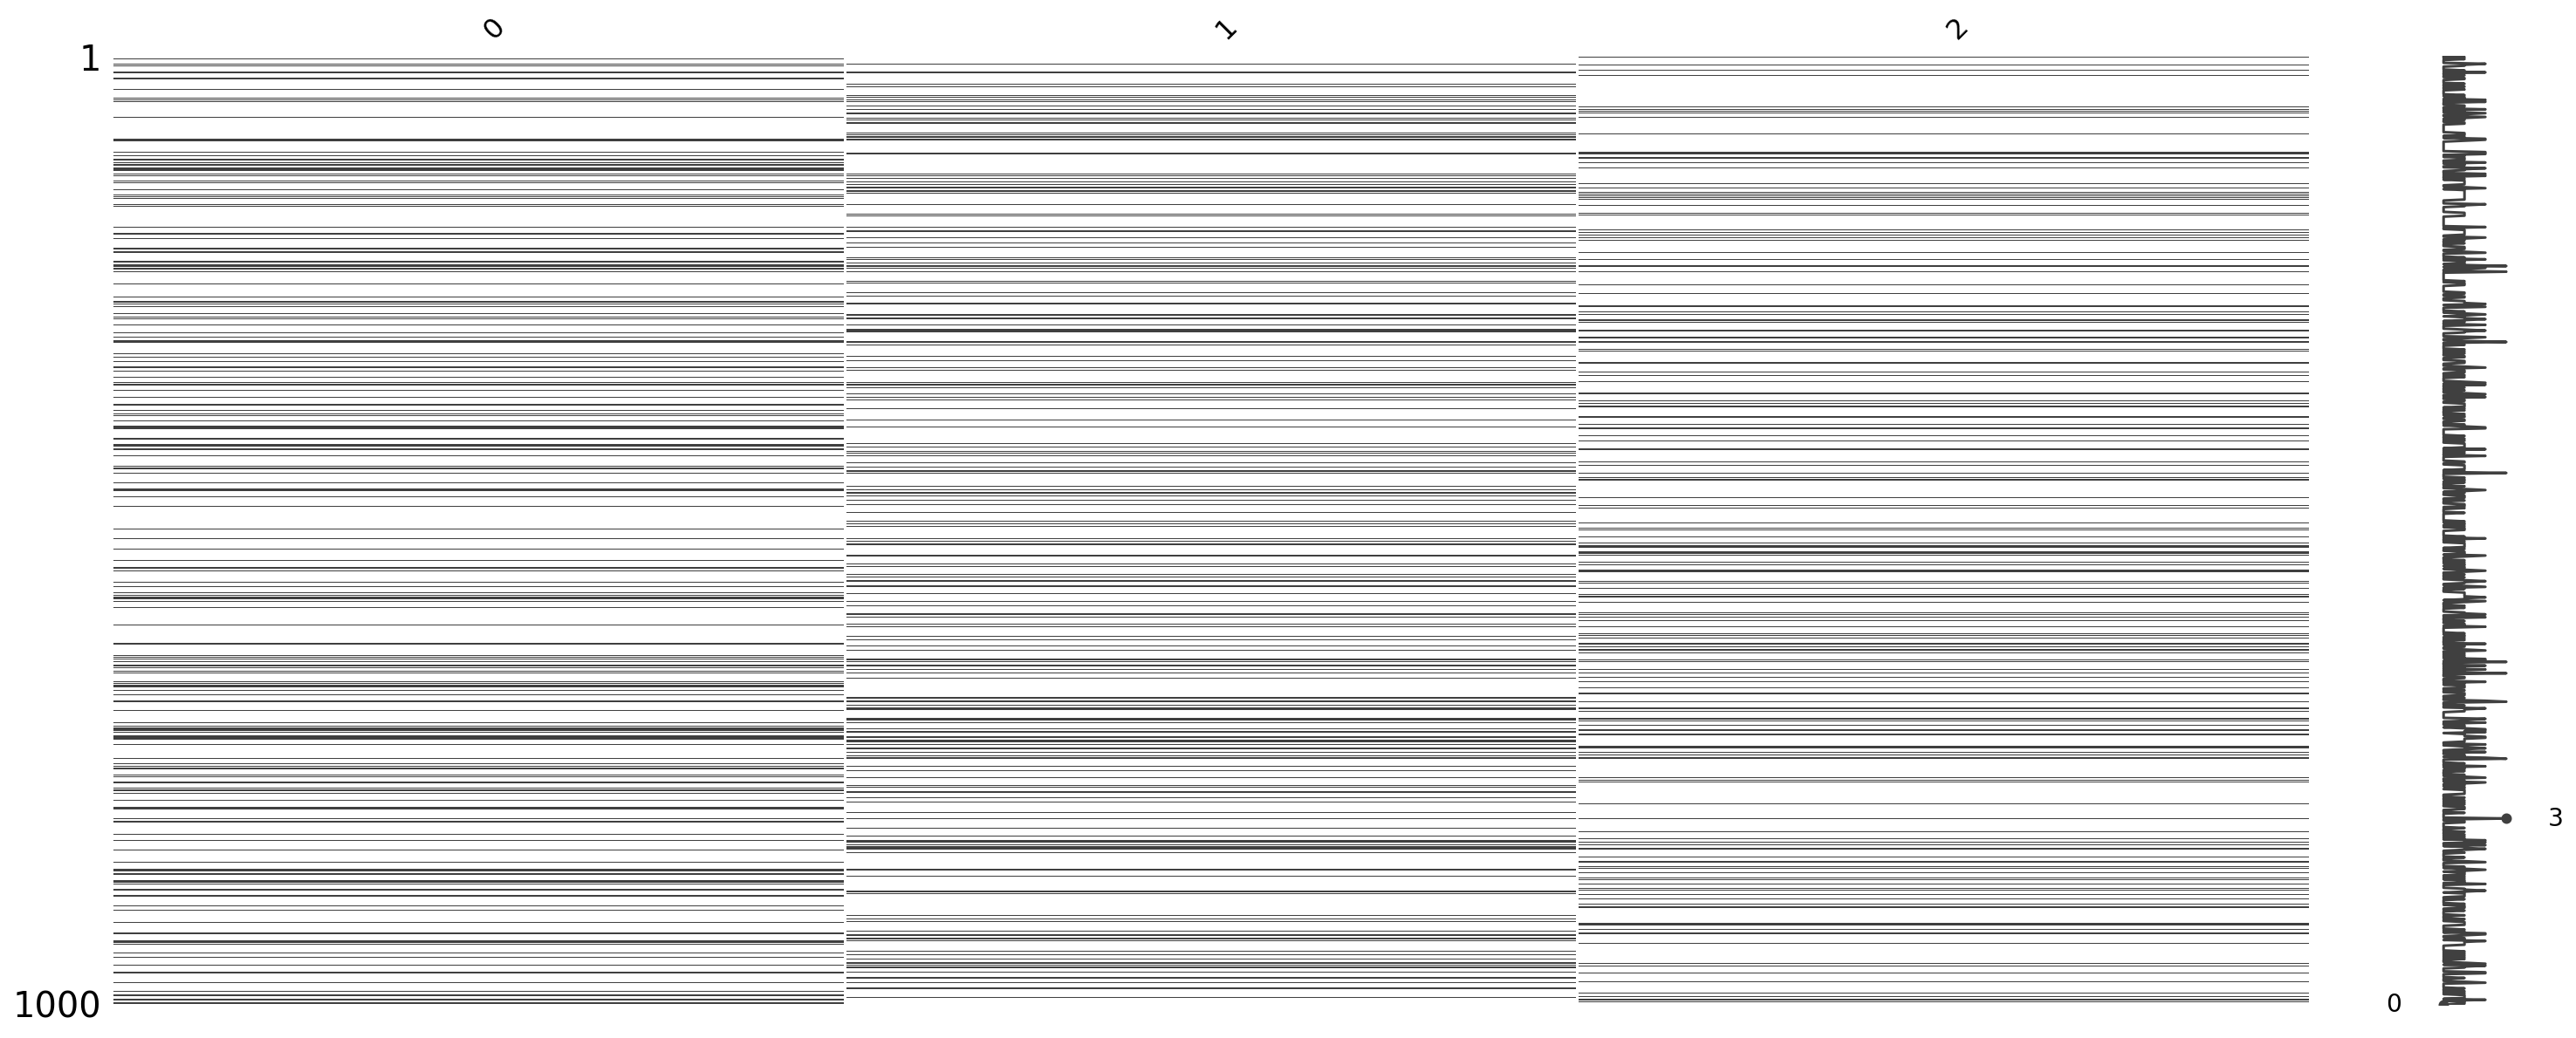

In [11]:
df_masked = pd.DataFrame(data_masked)
msno.matrix(df_masked)

In [12]:
import janitor

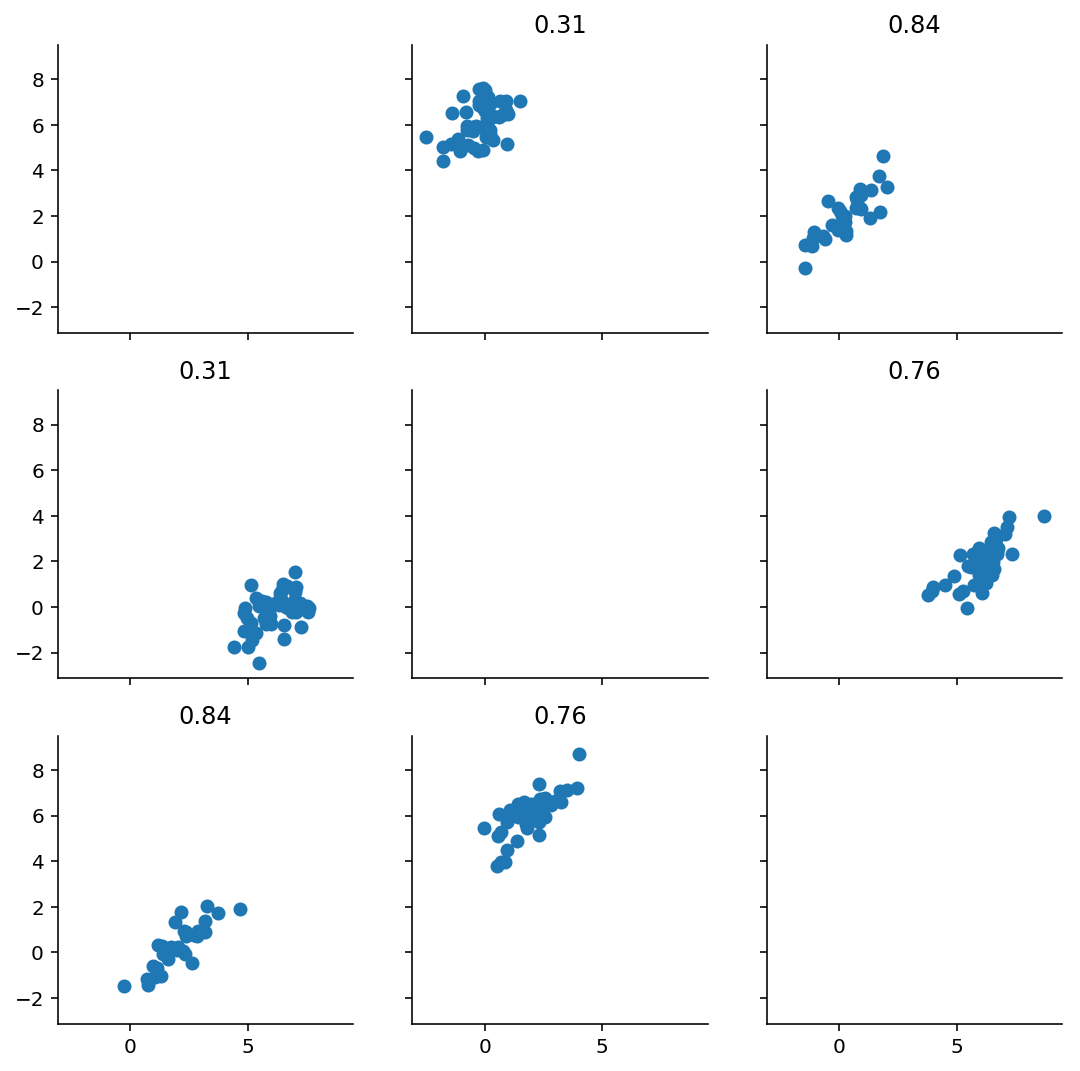

In [13]:
from itertools import combinations

fig, ax = plt.subplots(figsize=(9, 9), nrows=3, ncols=3, sharex=True, sharey=True)

covars = dict()
for r, c in combinations(df_masked.columns, 2):
#     print(r, c)
    df_filtered = df_masked[[r, c]].dropna()
#     print(df_filtered)
    ax[r, c].scatter(df_filtered[r], df_filtered[c])
    ax[c, r].scatter(df_filtered[c], df_filtered[r])
    covar = np.cov(df_filtered.T)
    ax[r, c].set_title(f"{covar[0, 1]:.2f}")
    ax[c, r].set_title(f"{covar[1, 0]:.2f}")
    
    covars[(r, c)] = covar
    covars[(c, r)] = covar

Now, let's say I have a new sample for which I only have data from column 0 and 1. Can we combine this information in a mathematically principled fashion so as to recover measurement of column 2 with uncertainty?

In [14]:
import pandas_flavor as pf

@pf.register_dataframe_method
def dropnotnull(df, column):
    return df[pd.isnull(df[column])]

In [15]:
df_unknown2 = df_masked.dropna(subset=[0, 1]).dropnotnull(2)

In [16]:
df_unknown2.head(5)

,0,1,2
8,-0.739596,5.969773,NaN
17,0.110442,6.068675,NaN
46,0.018543,6.626924,NaN
48,-1.428326,5.162053,NaN
87,0.295116,6.349655,NaN


In [17]:
from pprint import pprint

pprint(covars)

{(0, 1): array([[0.64482201, 0.31065304],
       [0.31065304, 0.72720156]]),
 (0, 2): array([[0.97882822, 0.84298507],
       [0.84298507, 1.05056106]]),
 (1, 0): array([[0.64482201, 0.31065304],
       [0.31065304, 0.72720156]]),
 (1, 2): array([[1.0151366 , 0.75757176],
       [0.75757176, 0.9881008 ]]),
 (2, 0): array([[0.97882822, 0.84298507],
       [0.84298507, 1.05056106]]),
 (2, 1): array([[1.0151366 , 0.75757176],
       [0.75757176, 0.9881008 ]])}


By the fundamental rule of multivariate normals, if we have a bivariate Normal distribution:

$$ X_1 X_2 \sim N(\mu, \Sigma)$$

Then if we know the value of $X_2=x_2$, then $X_1$ follows a distribution:

$$ X_1 \sim N(\mu_{1|2}, \Sigma_{1|2})$$

where 

$$\mu_{1|2} = \mu_1 + \Sigma_{12}\Sigma^{-1}_{22}(x_2-\mu_2)$$

and

$$\Sigma_{1|2} = \Sigma_{11} - \Sigma_{12} \Sigma^{-1}_{22} \Sigma_{21}$$

Thanks to the magic of Python, we can encode this in a function. Given two columns of data, we can estimate $\mu_1$ and $\mu_2$ and the covariance matrix $\Sigma$.

In [18]:
mu = df_masked.mean().values
mu

array([2.18759850e-03, 5.90808315e+00, 1.93279500e+00])

In [19]:
covars[(0, 2)]

# sigma = np.cov()

array([[0.97882822, 0.84298507],
       [0.84298507, 1.05056106]])

In [20]:
def mu_2g1(mu: np.ndarray, cov: np.ndarray, x_1: float):
    """
    :param mu: length-2 vector of mus.
    :param cov: 2x2 square covariance matrix.
    :param x_2: Known measurement.
    """
    sigma_21 = cov[1, 0]
    sigma_11 = cov[0, 0]
    mu_1 = mu[0]
    mu_2 = mu[1]
    return mu_2 + sigma_21 * 1 / sigma_11 * (x_1 - mu_1)

idx = df_unknown2.index[0]
print(mu_2g1(mu[[0, 2]], covars[(0, 2)], x_1=df_unknown2.loc[idx, 0]))
print(mu_2g1(mu[[1, 2]], covars[(1, 2)], x_1=df_unknown2.loc[idx, 1]))

1.2939569621738434
1.9788329872077353


In [24]:
def sig_2g1(cov):
    """
    :param cov: 2x2 covariance matrix.
    """
    if not cov.shape == (2, 2):
        raise ValueError("cov must be a 2x2 matrix")
    return cov[1, 1] - cov[1, 0] * 1 / cov[0, 0] * cov[0, 1]

pprint(sig_2g1(covars[(0, 2)]))
pprint(sig_2g1(covars[(1, 2)]))

0.3245666339057681
0.42274341652104686


In [25]:
df_masked[[0, 2]].mean().values

array([0.0021876, 1.932795 ])

In [44]:
def mu_sig(known_col, unknown_col):
    idx = df_unknown2.index[0]
    x_known = df_unknown2.loc[idx, known_col]
    mu = df_masked[[known_col, unknown_col]].mean().values
    cov = covars[(known_col, unknown_col)]
    mu = mu_2g1(mu, cov, x_known)
    sig = sig_2g1(cov)
    return mu, sig

In [45]:
mu_sig(0, 2)

(1.2939569621738434, 0.3245666339057681)

In [46]:
mu_sig(1, 2)

(1.9788329872077353, 0.42274341652104686)

In [47]:
from scipy.stats import norm

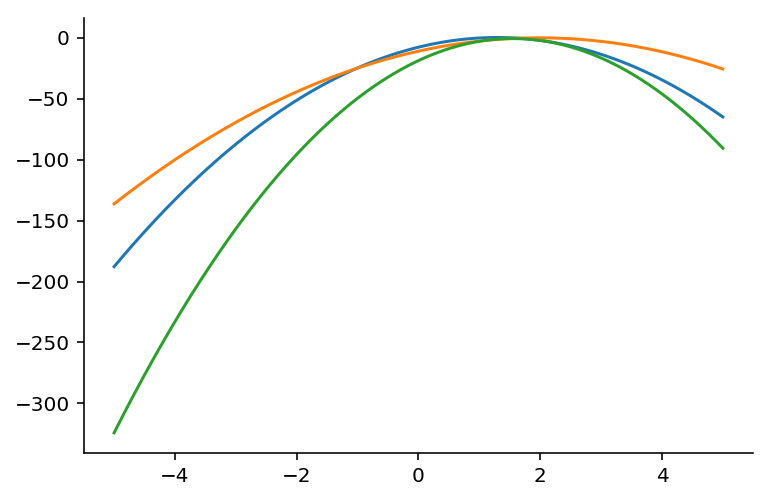

In [48]:
x = np.linspace(-5, 5, 1000)
logpdf1 = norm(*mu_sig(0, 2)).logpdf(x)
pdf1 = norm(*mu_sig(0, 2)).pdf(x)

logpdf2 = norm(*mu_sig(1, 2)).logpdf(x)
pdf2 = norm(*mu_sig(1, 2)).pdf(x)

plt.plot(x, logpdf1)
plt.plot(x, logpdf2)
plt.plot(x, logpdf1 + logpdf2)

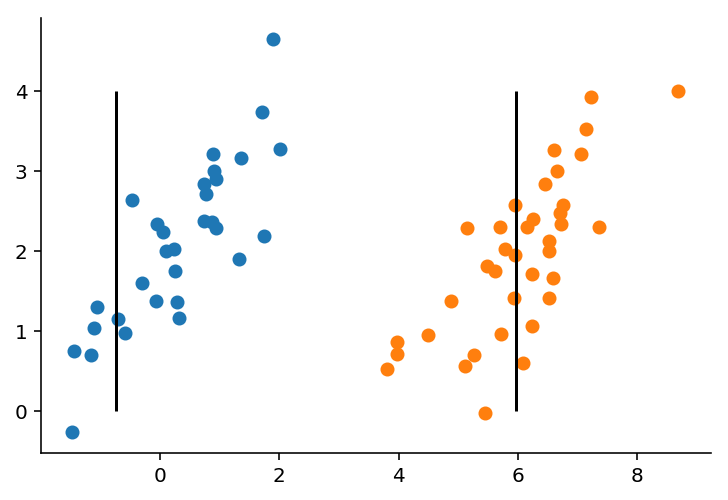

In [49]:
r = 0
c = 2
df_filtered = df_masked[[r, c]].dropna()
plt.scatter(*df_filtered.T.values)
plt.vlines(x=df_unknown2.loc[idx, r], ymin=0, ymax=4)

r = 1
c = 2
df_filtered = df_masked[[r, c]].dropna()
plt.scatter(*df_filtered.T.values)
plt.vlines(x=df_unknown2.loc[idx, r], ymin=0, ymax=4)


In [50]:
idx = df_unknown2.index[0]
df.loc[idx]

0   -0.739596
1    5.969773
2    1.438907
Name: 8, dtype: float64

In [51]:
sumlogpdf = logpdf1 + logpdf2
x[np.where(sumlogpdf == sumlogpdf.max())]

array([1.54654655])

(0, 2)

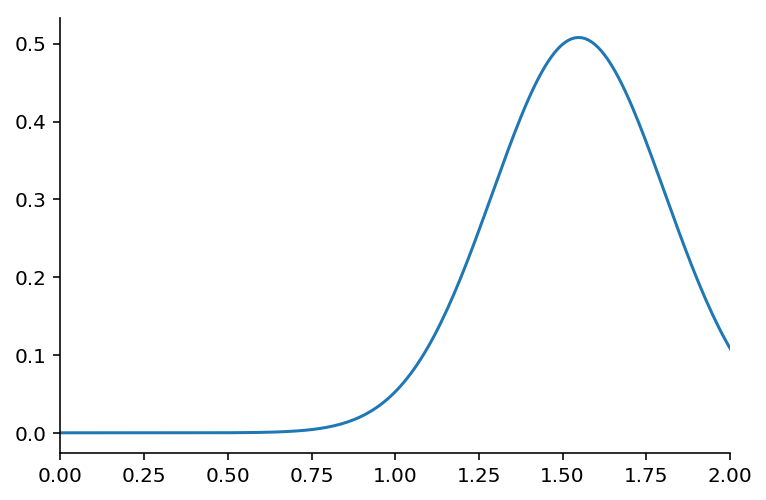

In [52]:
plt.plot(x, pdf1 * pdf2)
plt.xlim(0, 2)

It works! We can use fully probabilistic methods that are mathematically principled to obtain estimates of unknown data, given that we know the joint distribution.